In [11]:
import os
import numpy as np
import tensorflow as tf
from easydict import EasyDict as edict
import matplotlib.pyplot as plt

# modules
from dataloader import Cifar10DataLoader, MnistDataLoader
from dnn import DNN

In [12]:
dataloader_args = edict({"batch_size": 128, "epochs": 20, "da": False})
dataloader = MnistDataLoader(dataloader_args=dataloader_args)
train_dataset, valid_dataset, test_dataset = dataloader.load_dataset()

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Predicted Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def plot_train(display_list):
  # plt.figure(figsize=(10, 10))
  label = ['Train', 'Test']
  for i in range(len(display_list)):
    plt.plot(display_list[i], label=label[i])
  plt.legend()
  plt.show()
  

In [13]:
model_args = edict({"units":[128,64,32,10], "activations":["relu","relu","relu","softmax"]})
model = DNN(units=model_args.units, activations=model_args.activations)

In [14]:
train_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mt_loss_fn = tf.keras.metrics.Mean()
test_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mte_loss_fn = tf.keras.metrics.Mean()
opt_loss = tf.keras.losses.categorical_crossentropy

train_metrics = tf.keras.metrics.CategoricalAccuracy()
test_metrics = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(0.1)

In [15]:
# @tf.function(experimental_relax_shapes=True, experimental_compile=None)
def _train_step(inputs, labels, first_batch=False):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = train_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(train_metrics(labels, predictions))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    mt_loss_fn.update_state(loss)
    
    return loss, metrics

def _test_step(inputs, labels):
    predictions = model(inputs)
    loss = test_loss_fn(labels, predictions)
    opt_label = opt_loss(labels, predictions)
    metrics = tf.reduce_mean(test_metrics(labels, predictions))
    mte_loss_fn.update_state(loss)
    
    return loss, metrics, opt_label

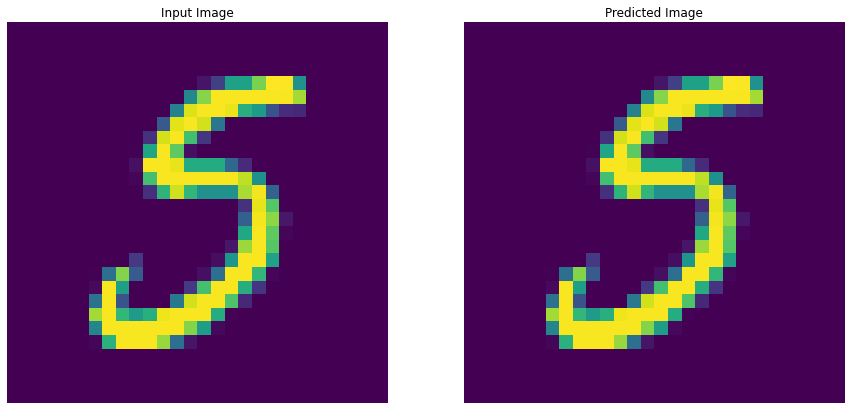

In [16]:
iter_train = iter(train_dataset)
iter_valid = iter(valid_dataset)
iter_test = iter(test_dataset)
test_data =  iter_test.get_next()

display([test_data["inputs"][0],test_data["inputs"][0]])

In [17]:
model_opt = []
opt_label = []
def collect_model_operator(variables, loss):
    weights = [w.numpy() for w in variables]
    opt = DNN(units=model_args.units, 
            activations=model_args.activations,
            init_value=weights)
    opt_label.append(loss)
    model_opt.append(opt)

records = edict({'epoch':[],'train_loss':[],'test_loss':[],'train_metric':[],'test_metric':[]})
def obtain_model_opts(sample_gap=20):
    for e in range(dataloader.info.epochs):
        mt_loss_fn.reset_states()
        train_metrics.reset_states()
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(dataloader.info.train_step):
            data = iter_train.get_next()
            train_loss, acc = _train_step(inputs=data["inputs"], labels=data["labels"])
            if (e*dataloader.info.train_step + step)%sample_gap ==0:
                test_loss, test_acc, opt_label = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
                collect_model_operator(model.trainable_variables, test_loss)
                
        records.epoch        += [e]
        records.train_loss   += [mt_loss_fn.result().numpy()]
        records.train_metric += [train_metrics.result().numpy()]
        records.test_loss    += [mte_loss_fn.result().numpy()]
        records.test_metric  += [test_metrics.result().numpy()]
        log = ""
        for k,v in records.items():
            log += "{}: {} ".format(k,v[-1])
        print(log)

In [18]:

def init_model_opt(raw_model_opt, data):
    
    def opt_test_step(opt, inputs, labels):
        predictions = opt(inputs)
        loss = test_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(test_metrics(labels, predictions))
        mte_loss_fn.update_state(loss)
        return loss, metrics

    for idx in range(len(raw_model_opt)):
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(1):
            data = test_data
            test_loss, test_acc = opt_test_step(opt=raw_model_opt[idx], inputs=data["inputs"], labels=data["labels"])
        print("Init: opt_id:{}, Test loss:{}, Test acc:{}".format(idx,
                                                        mte_loss_fn.result().numpy(),
                                                        test_metrics.result().numpy()))
            
def hard_save_model_opt(online_model_opt, path="./model_opt"):
    init_model_opt(online_model_opt, test_data)
    for idx in range(len(online_model_opt)):
        mpath = os.path.join(path, "opt_{}".format(idx))
        online_model_opt[idx].save(mpath, overwrite=True, save_format='tf')

def load_model_opt(path="./model_opt"):
    offline_model_opt = []
    model_opt_list = os.listdir(path=path)
    for idx in range(len(model_opt_list)):
        mpath = os.path.join(path,  "opt_{}".format(idx))
        offline_model_opt.append(tf.keras.models.load_model(mpath))
    init_model_opt(offline_model_opt, test_data)
    return offline_model_opt

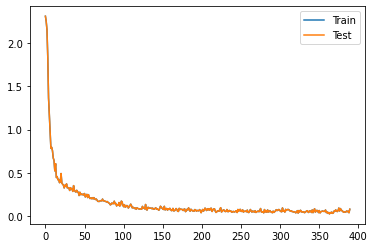

In [22]:
# code test


In [20]:
# training
obtain_model_opts(sample_gap=20) 
print(len(model_opt))

epoch: 0 train_loss: 0.9408418536186218 test_loss: 0.9677136540412903 train_metric: 0.6799078583717346 test_metric: 0.6792969107627869 
epoch: 1 train_loss: 0.3286469876766205 test_loss: 0.3392532765865326 train_metric: 0.9031631350517273 test_metric: 0.8984375 
epoch: 2 train_loss: 0.24663417041301727 test_loss: 0.2468700259923935 train_metric: 0.9262548685073853 test_metric: 0.916796863079071 
epoch: 3 train_loss: 0.1885223090648651 test_loss: 0.18515031039714813 train_metric: 0.943333089351654 test_metric: 0.9333881735801697 
epoch: 4 train_loss: 0.15518784523010254 test_loss: 0.14429917931556702 train_metric: 0.9536161422729492 test_metric: 0.944140613079071 
epoch: 5 train_loss: 0.13013523817062378 test_loss: 0.11050038784742355 train_metric: 0.9607973098754883 test_metric: 0.9588815569877625 
epoch: 6 train_loss: 0.11006798595190048 test_loss: 0.09049724042415619 train_metric: 0.9678680300712585 test_metric: 0.9671875238418579 
epoch: 7 train_loss: 0.09555160254240036 test_loss: 

In [ ]:
# save model opt
hard_save_model_opt(model_opt)

In [ ]:
# load model opt
# off_model_opt = load_model_opt()

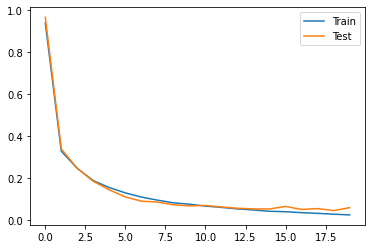

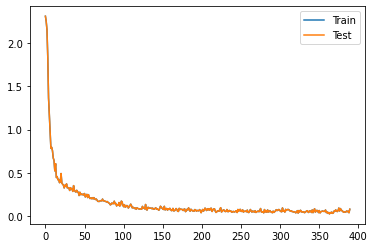

In [23]:
#metrics visualization
plot_train([records.train_loss,records.test_loss])
plot_train([opt_label,opt_label])